### First set number of cores on machine to use and SSID number to analyse, then run all

In [1]:
# setting variables

cores = 3 # enter the number of cores to use here, in place of x
SSIDno = 44561284 # enter the SSID number to model as an int here, in place of xxxxxxxx

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches
#import matplotlib.font_manager as fm
import matplotlib
import autotime
%matplotlib inline
%load_ext autotime
#import seaborn as sns
import statsmodels as stm
import statsmodels.formula.api as sm
from sklearn.feature_selection import VarianceThreshold
from sklearn import metrics
from sklearn.linear_model import LinearRegression as LinR
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV as RSCV
# from dask_searchcv import RandomizedSearchCV as DRSCV
# from sklearn.pipeline import Pipeline
from sklearn.metrics.scorer import make_scorer
# from sklearn.preprocessing import MinMaxScaler as MMS
from scipy import stats
from scipy.stats import randint

#from sklearn.tree import export_graphviz
#from IPython.display import Image

## 1. Data processing stage

First, select route files to input based on SSIDno to analyse

### 1a Inputting data and creating dataframe for SSIDno

In [3]:
# Read in stop_times.txt and trips.txt files from NTA data
stop_times_2012 = pd.read_csv('stop_times.txt')
trips_2012 = pd.read_csv('trips.txt')

# Merge by trip_id
merge = pd.merge(stop_times_2012, trips_2012, on='trip_id', how='outer')

# Keep only necessary columns
merge.drop(['arrival_time','departure_time','pickup_type','drop_off_type','service_id','shape_dist_traveled'], axis=1, inplace=True)

# Transform trip_id to route and stop_id to StopID
merge['route_short'] = merge['trip_id'].apply(lambda x: x[x.index('-')+1:])
merge['route_short'] = merge['route_short'].apply(lambda x: x[: x.index('-')])
merge['route_short'] = merge['route_short'].apply(lambda x: str(x).zfill(4))
merge['StopID'] = merge['stop_id'].apply(lambda x: x[-4:])

# Find StopID and the sequence of that shape_id
gb = merge.groupby(['shape_id', 'route_short', 'direction_id','stop_sequence', 'StopID'])
gbc = gb.count()
gbc.reset_index(['shape_id', 'route_short', 'direction_id','stop_sequence', 'StopID'], inplace=True)
transit_shapeID_stopID = gbc.drop(['trip_id','stop_id','route_id','trip_headsign'], axis=1)

# create list of pairs of routes and the SSIDs contained within them
ssid = []
for i in range(len(transit_shapeID_stopID.index)-1):
    temp = transit_shapeID_stopID['StopID'].iloc[i] + transit_shapeID_stopID['StopID'].iloc[i+1]
    ssid.append([ transit_shapeID_stopID['route_short'].iloc[i],temp])
    
SSIDnoStr = str(SSIDno).zfill(8)
routes = [x for x in ssid if SSIDnoStr in x[1]]
routes = [item[0] for item in routes]
routes = list(set(routes))

# Reading in the route CSV files for the required SSID

res = pd.read_csv('Route_XXXX_travel_time_csvs/Blank_Route_travel_time.csv')
route_list = routes
for r in route_list:
    df = pd.read_csv('Route_XXXX_travel_time_csvs/Route_%s_travel_time.csv' % r)
    res = pd.concat([df, res], axis=0) 

time: 7.63 s


In [4]:
# create dataframe for SSIDno

res['SSID'] = res['SSID'].astype('category')
ssid_df = res[res.SSID == SSIDno]
ssid_df.reset_index(inplace=True)
ssid_df = ssid_df.drop('index', axis=1)
ssid_df.shape

(15766, 12)

time: 219 ms


In [5]:
ssid_df.memory_usage(deep=True)

Index                    80
Day                 1012640
DestStopID           126128
HourFrame            126128
JourneyPatternID     620994
Rain                 126128
SSID                 235404
SchoolHoliday         15766
SourceStopID         126128
TimeFrame           1056322
TravelTime           126128
VehicleJourneyID     126128
WindSpeed            126128
dtype: int64

time: 10 ms


In [6]:
JPID_Count = ssid_df.JourneyPatternID.unique().shape[0]
Row_Count = ssid_df.shape[0]
print("There are", JPID_Count, "unique JPIDs traversing this segment, over the course of", Row_Count, "observations.")

There are 19 unique JPIDs traversing this segment, over the course of 15766 observations.
time: 43 ms


In [7]:
# add leading zeroes to JourneyPatternID

ssid_df.JourneyPatternID = ssid_df.JourneyPatternID.astype('object')
ssid_df.JourneyPatternID = ssid_df.JourneyPatternID.apply(lambda x: str(x).zfill(8))

time: 44 ms


### 1b Adding extra features and altering/dropping existing ones

In [8]:
# adding Xbuses feature - boolean feature indicating whether or not the JourneyPatternID represents an express (X) bus

ssid_df['XBuses'] = ssid_df[ssid_df["JourneyPatternID"].str.find("X") > 0].sum(axis=1) > 0
ssid_df["XBuses"].fillna(False, inplace=True)
ssid_df['XBuses'] = ssid_df['XBuses'].astype('int')

time: 46 ms


In [9]:
# adding JPID_length feature - represents the total number of stops traversed by this JourneyPatternID along its entire route

JPIDL = pd.read_csv('JPID_Length.csv')
JPIDL = JPIDL.drop('Unnamed: 0', axis=1)
ssid_df = pd.merge(left=ssid_df ,right=JPIDL, how='left', left_on='JourneyPatternID', right_on='JourneyPatternID')
ssid_df = ssid_df.dropna()
ssid_df.shape

(15766, 14)

time: 66 ms


In [10]:
# NOTE: feature currently not being used due to issues with inputting it to the model

# adding JPID_Freq feature - represents how often in the given data this JourneyPatternID traversed this segment

# ssid_df['JPID_Freq'] = ssid_df.groupby(['JourneyPatternID'])['JourneyPatternID'].transform('count')

time: 1 ms


In [11]:
# removing non-holiday-period weekends from SchoolHoliday feature to avoid multi-collinearity issues

ssid_df['SchoolHoliday'] = ssid_df['SchoolHoliday'].astype('int')
ssid_df['SchoolHoliday'] = np.where(ssid_df['TimeFrame'].isin(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05', '2013-01-06']), 1, 0)

time: 41 ms


In [12]:
# fetching SSID number from dataframe for CSV file naming purposes

res.SSID = res.SSID.apply(lambda x: str(int(x)).zfill(8))
r = ssid_df.loc[0, 'SSID'] 

time: 52 ms


In [13]:
# dropping unneeded columns

ssid_df = ssid_df.drop(['SourceStopID', 'DestStopID', 'VehicleJourneyID', 'JourneyPatternID', 'SSID'], axis=1)

# reordering remaining columns

ssid_df = ssid_df[['TravelTime', 'Rain', 'WindSpeed', 'JPID_length', 'XBuses', 'SchoolHoliday', 'Day', 'HourFrame']]

time: 26 ms


In [14]:
ssid_df

,TravelTime,Rain,WindSpeed,JPID_length,XBuses,SchoolHoliday,Day,HourFrame
0,60,0.000000,15.0,76,0,0,Tuesday,8
1,78,0.000000,17.5,76,0,0,Tuesday,12
2,25,0.000000,15.5,76,0,0,Tuesday,16
3,60,0.000000,15.5,76,0,0,Tuesday,9
4,60,0.000000,17.0,76,0,0,Tuesday,13
5,61,0.000000,15.5,76,0,0,Tuesday,16
6,60,0.000000,17.5,76,0,0,Tuesday,11
7,41,0.000000,15.5,76,0,0,Tuesday,9
8,39,0.000000,17.0,76,0,0,Tuesday,13
9,60,0.000000,14.0,76,0,0,Tuesday,17


time: 57 ms


In [15]:
# assigning appropriate datatypes where necessary

ssid_df['Day'] = ssid_df['Day'].astype('category')
ssid_df['HourFrame'] = ssid_df['HourFrame'].astype('category')
ssid_df['JPID_length'] = ssid_df['JPID_length'].astype('int')

time: 73 ms


In [16]:
# removing any constant features
# code from: https://stackoverflow.com/questions/20209600/panda-dataframe-remove-constant-column

ssid_df = ssid_df.loc[:,ssid_df.apply(pd.Series.nunique) != 1]

time: 50 ms


In [17]:
ssid_df

,TravelTime,Rain,WindSpeed,JPID_length,SchoolHoliday,Day,HourFrame
0,60,0.000000,15.0,76,0,Tuesday,8
1,78,0.000000,17.5,76,0,Tuesday,12
2,25,0.000000,15.5,76,0,Tuesday,16
3,60,0.000000,15.5,76,0,Tuesday,9
4,60,0.000000,17.0,76,0,Tuesday,13
5,61,0.000000,15.5,76,0,Tuesday,16
6,60,0.000000,17.5,76,0,Tuesday,11
7,41,0.000000,15.5,76,0,Tuesday,9
8,39,0.000000,17.0,76,0,Tuesday,13
9,60,0.000000,14.0,76,0,Tuesday,17


time: 50 ms


In [18]:
# save as csv

ssid_df.to_csv('SSID_CSVs/SSID_%s.csv' % r)

time: 110 ms


## 1c. Dropping Outliers

#### Visualising range of travel-time data first

Histiogram of values (x-axis is number of seconds)

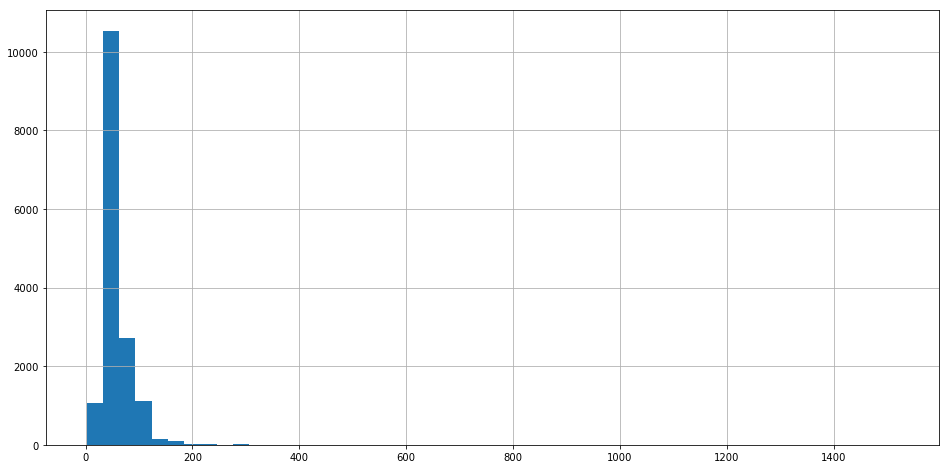

time: 229 ms


In [19]:
ssid_df.TravelTime.hist(figsize=(16, 8), bins=50)

Boxplot to check for outliers

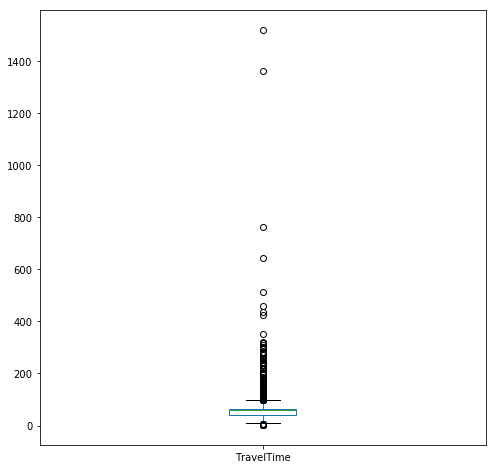

time: 203 ms


In [20]:
ssid_df.TravelTime.plot(kind='box', figsize=(8, 8), showfliers=True)

In [21]:
# Checking stats for TravelTime

ssid_df.TravelTime.describe()

count    15766.000000
mean        59.232589
std         32.606534
min          2.000000
25%         41.000000
50%         59.000000
75%         64.000000
max       1521.000000
Name: TravelTime, dtype: float64

time: 7 ms


Dropping outliers

In [22]:
# loading table of minimum times to traverse segments at 65kmph

find_lb = pd.read_csv('use_speed_and_distance_get_outlier_bound.csv')

# extracting value for this segment, to use as lower bound for outlier removal

lb = find_lb.loc[find_lb['SSID'] == SSIDno, 'min_sec'].iloc[0]
print(lb)

11.2607119134
time: 25 ms


In [23]:
# make a copy of original df

trimssid_df = ssid_df.copy()

# Remove TravelTime upper bound outliers beyond 2 x IQR, and lowerbound below 'lb'

ub = trimssid_df.quantile(q=.75) + (2*(trimssid_df.quantile(q=.75)-trimssid_df.quantile(q=.25)))
trimssid_df['OutlierTT'] = (trimssid_df['TravelTime'] < lb) | (trimssid_df['TravelTime'] > ub['TravelTime'])

# Outlier rows counted

print("There will be", trimssid_df[(trimssid_df['OutlierTT'] == True)].shape[0], "outliers dropped.")

There will be 691 outliers dropped.
time: 17 ms


In [24]:
# dropping outliers

trimssid_df = trimssid_df[trimssid_df.OutlierTT != True]
trimssid_df.sort_values(['TravelTime'], ascending=False, inplace=True)
trimssid_df = trimssid_df.drop(['OutlierTT'], axis=1)
trimssid_df.reset_index(inplace=True)
trimssid_df = trimssid_df.drop('index', axis=1)
trimssid_df

,TravelTime,Rain,WindSpeed,JPID_length,SchoolHoliday,Day,HourFrame
0,110,0.000000,9.5,71,0,Thursday,8
1,110,0.000000,7.0,76,0,Tuesday,18
2,110,0.000000,2.5,76,0,Wednesday,15
3,109,0.000000,1.5,60,0,Wednesday,12
4,109,0.000000,7.0,76,0,Wednesday,9
5,108,0.000000,7.0,74,0,Tuesday,8
6,108,0.633301,4.0,53,0,Wednesday,14
7,108,0.066650,9.5,66,0,Monday,11
8,108,0.000000,10.5,60,0,Wednesday,12
9,108,0.000000,6.0,60,0,Sunday,17


time: 62 ms


In [25]:
# Create TT mean/median value variables, to use in calculating mean/median absolute percentage accuracy scores
# and for horizontal lines in the charts below to represent the mean/medium

ssid_df = trimssid_df
ssid_df_mean = ssid_df.TravelTime.mean()
ssid_df_median  = ssid_df.TravelTime.median()
ssid_df.TravelTime.describe()

count    15075.000000
mean        55.282786
std         19.484608
min         13.000000
25%         40.000000
50%         59.000000
75%         62.000000
max        110.000000
Name: TravelTime, dtype: float64

time: 7 ms


#### Visualising range of data after dropping outliers

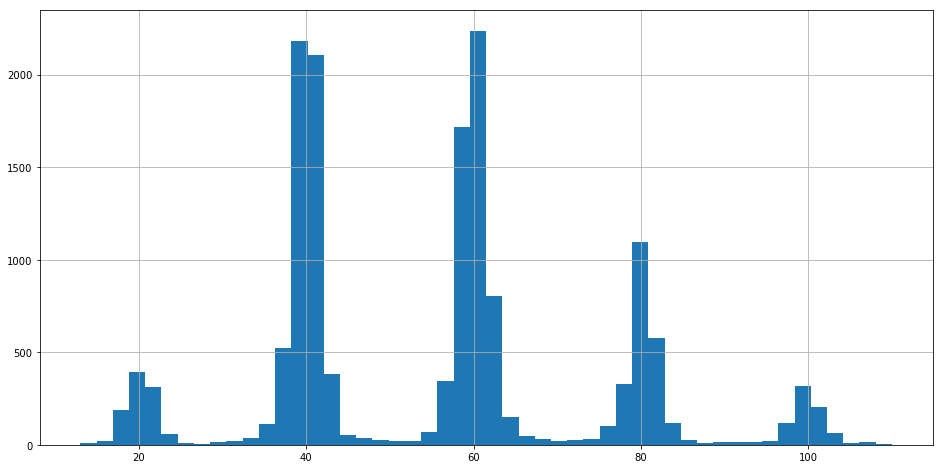

time: 203 ms


In [26]:
ssid_df.TravelTime.hist(figsize=(16, 8), bins=50)

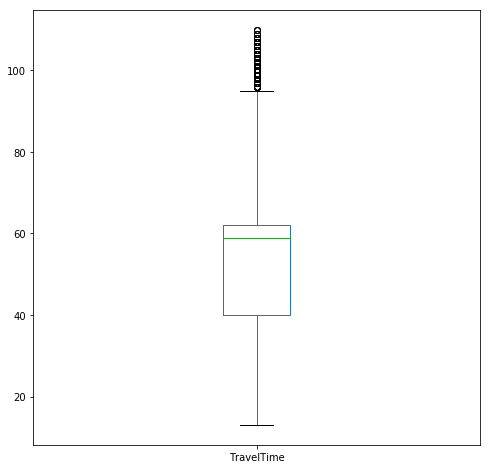

time: 195 ms


In [27]:
ssid_df.TravelTime.plot(kind='box', figsize=(8, 8), showfliers=True)

## 2. Visualising the data

### 2ai Bar plot for mean TravelTime per HourFrame

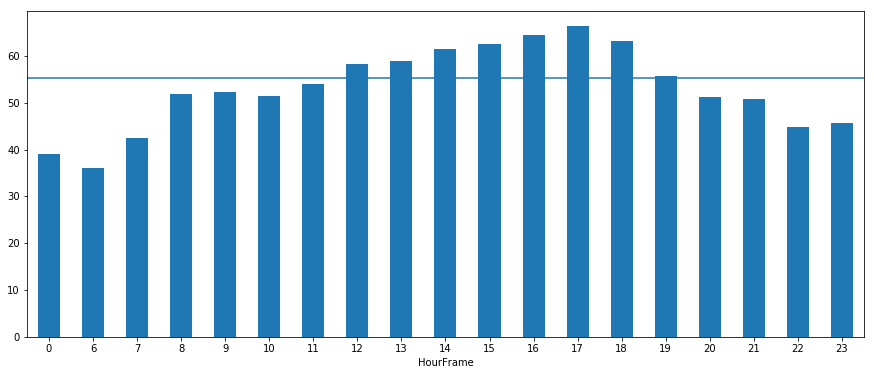

time: 184 ms


In [28]:
mean_HF = ssid_df.groupby('HourFrame')['TravelTime'].mean()
mean_HF.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean
coord_x2 = 25

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2aii Bar plot for median TravelTime per HourFrame

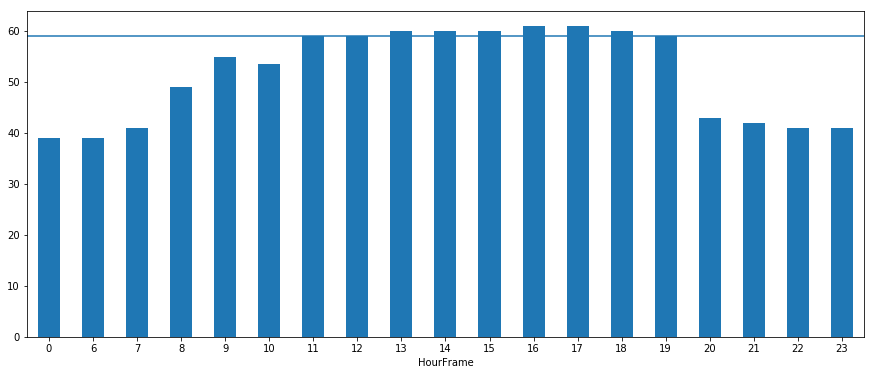

time: 187 ms


In [29]:
med_HF = ssid_df.groupby('HourFrame')['TravelTime'].median()
med_HF.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 25

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2bi Bar plot for mean TravelTime per Day

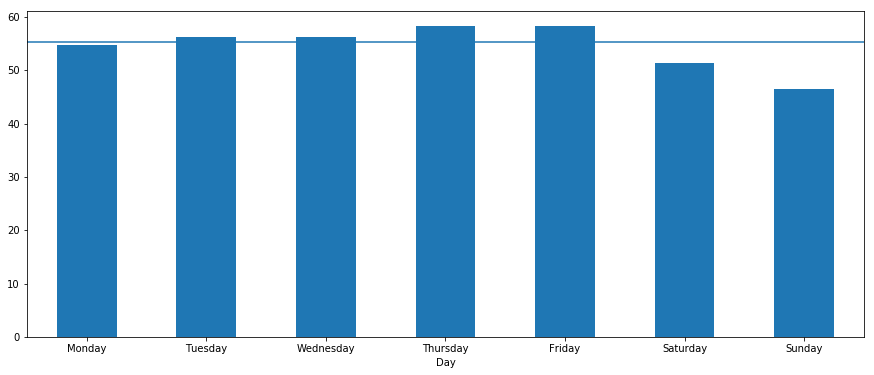

time: 148 ms


In [30]:
mean_Day = ssid_df.groupby('Day')['TravelTime'].mean()
mean_Day=mean_Day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

mean_Day.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean

coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2bii Bar plot for median TravelTime per HourFrame

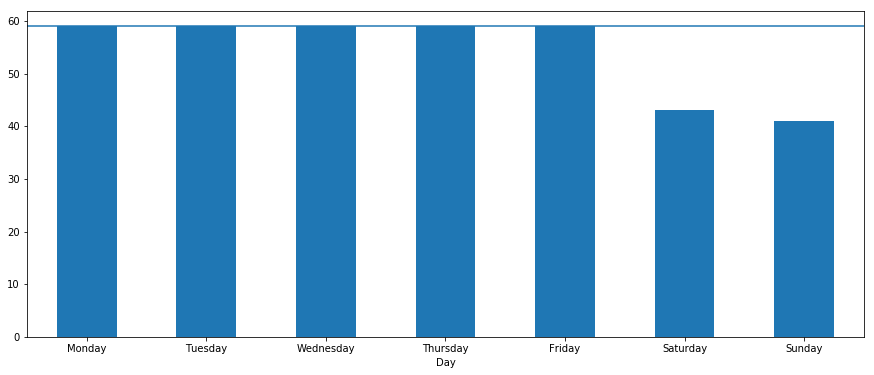

time: 146 ms


In [31]:
med_Day = ssid_df.groupby('Day')['TravelTime'].median()

med_Day=med_Day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
med_Day.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation: 

### 2ci Bar plot for mean TravelTime when SchoolHoliday true/false

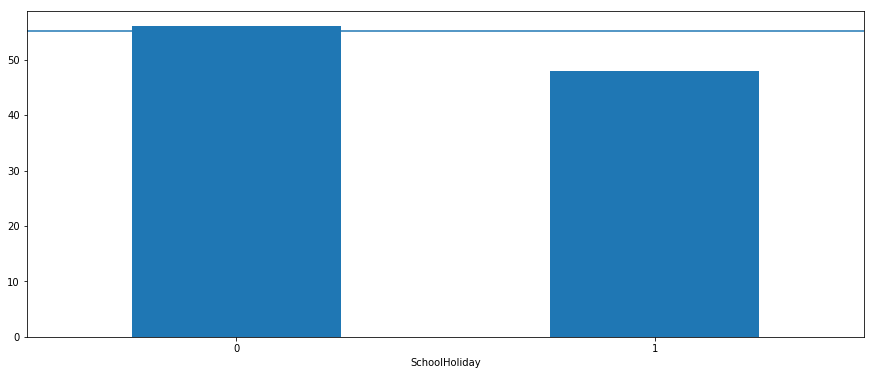

time: 161 ms


In [32]:
mean_SH = ssid_df.groupby('SchoolHoliday')['TravelTime'].mean()
mean_SH.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2cii Bar plot for median TravelTime when SchoolHoliday true/false

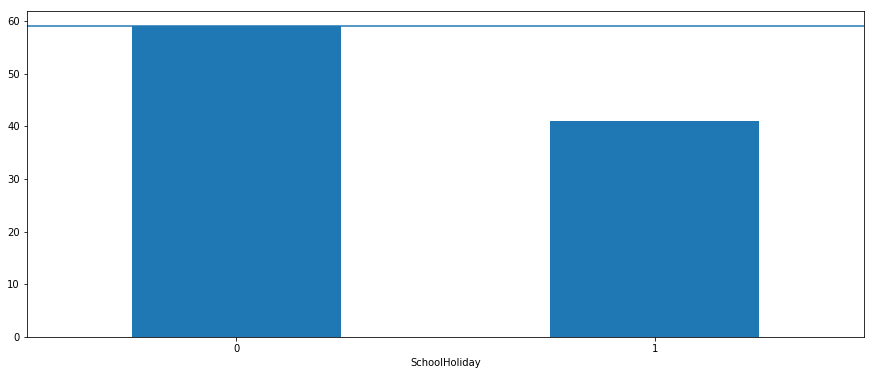

time: 128 ms


In [33]:
med_SH = ssid_df.groupby('SchoolHoliday')['TravelTime'].median()
med_SH.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Splitting data into 70% for training and 30% for testing

## 3 Model training (Scikit-learn)

First we need to dreate dummy variables for categorical features, and split into test and training sets

### 3.1 Prepare data for modelling via Scikit-learn

In [34]:
# create dummy variables from HourFrame and Day using get_dummies
# dropping first values to avoid multicollinearity (Day = Friday, Hour = 0 or 6 or 7, depending on SSID)

Day_dummies = pd.get_dummies(ssid_df.Day, prefix='Day', drop_first=True)
HF_dummies = pd.get_dummies(ssid_df.HourFrame, prefix='HF', drop_first=True)

# concatenate the dummy variable columns onto the original DataFrame and drop the original features
ssid_df = pd.concat([ssid_df, HF_dummies, Day_dummies], axis=1)
ssid_df = ssid_df.drop(['HourFrame', 'Day'], axis=1)
ssid_df

,TravelTime,Rain,WindSpeed,JPID_length,SchoolHoliday,HF_6,HF_7,HF_8,HF_9,HF_10,...,HF_20,HF_21,HF_22,HF_23,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
0,110,0.000000,9.5,71,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,110,0.000000,7.0,76,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,110,0.000000,2.5,76,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,109,0.000000,1.5,60,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,109,0.000000,7.0,76,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
5,108,0.000000,7.0,74,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
6,108,0.633301,4.0,53,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,108,0.066650,9.5,66,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8,108,0.000000,10.5,60,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,108,0.000000,6.0,60,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


time: 54 ms


In [35]:
# prepare a list containing all remaining features bar the target
pred_features = list(ssid_df)
pred_features.remove('TravelTime')
print(pred_features)

['Rain', 'WindSpeed', 'JPID_length', 'SchoolHoliday', 'HF_6', 'HF_7', 'HF_8', 'HF_9', 'HF_10', 'HF_11', 'HF_12', 'HF_13', 'HF_14', 'HF_15', 'HF_16', 'HF_17', 'HF_18', 'HF_19', 'HF_20', 'HF_21', 'HF_22', 'HF_23', 'Day_Monday', 'Day_Saturday', 'Day_Sunday', 'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday']
time: 2 ms


In [36]:
# prepare target/predictive feature variables for use in scikit-learn modelling

X = ssid_df[pred_features]
y = ssid_df['TravelTime']

time: 3 ms


In [37]:
# split the data into training portion (70%) and final testing potion (30%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 38)

time: 5 ms


### 3bi Linear Regression model (via scikit-learn) - training - default parameters

In [38]:
lr = LinR(n_jobs = cores)
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=3, normalize=False)

time: 66 ms


In [39]:
lr_pred = lr.predict(X_train)
lr_rsq = metrics.r2_score(y_train, lr_pred)
print ("The R-squared value of the Linear Regression model is", lr_rsq)

The R-squared value of the Linear Regression model is 0.21175685682
time: 19 ms


In [40]:
lr_mae = metrics.mean_absolute_error(y_train, lr_pred)
print ("The mean absolute error of the Linear Regression model is", lr_mae)
print ("The mean absolute percentage error is", (((lr_mae)/ssid_df_mean)*100))

The mean absolute error of the Linear Regression model is 13.6954954324
The mean absolute percentage error is 24.7735260939
time: 12 ms


In [41]:
lr_mdae = metrics.median_absolute_error(y_train, lr_pred)
print ("The median absolute error of the Linear Regression model is", lr_mdae)
print ("The median absolute percentage error is", (((lr_mdae)/ssid_df_median)*100))

The median absolute error of the Linear Regression model is 11.2931271411
The median absolute percentage error is 19.1408934594
time: 30 ms


### 3bii Linear Regression model (via scikit-learn) - testing - default parameters

In [42]:
lr_preda = lr.predict(X_test)
lr_rsqa = metrics.r2_score(y_test, lr_preda)
print ("The R-squared value of the Linear Regression model is", lr_rsqa)

The R-squared value of the Linear Regression model is 0.198067333531
time: 18 ms


In [43]:
lr_maea = metrics.mean_absolute_error(y_test, lr_preda)
print ("The mean absolute error of the Linear Regression model is", lr_maea)
print ("The mean absolute percentage error is", (((lr_maea)/ssid_df_mean)*100))

The mean absolute error of the Linear Regression model is 13.9248894671
The mean absolute percentage error is 25.1884726822
time: 8 ms


In [44]:
lr_mdaea = metrics.median_absolute_error(y_test, lr_preda)
print ("The median absolute error of the Linear Regression model is", lr_mdaea)
print ("The median absolute percentage error is", (((lr_mdaea)/ssid_df_median)*100))

The median absolute error of the Linear Regression model is 11.4711335341
The median absolute percentage error is 19.4425992104
time: 5 ms


### 3ci Support Vector Machine Regression with RBF Kernel model - training - default parameters

In [45]:
svr_rbf = SVR(kernel='rbf')
svr_rbf.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

time: 6.04 s


In [46]:
svr_rbf_pred = svr_rbf.predict(X_train)
svr_rbf_rsq = metrics.r2_score(y_train, svr_rbf_pred)
print ("The R-squared value of the SVR with RBF Kernel model is", svr_rbf_rsq)

The R-squared value of the SVR with RBF Kernel model is 0.0889487058281
time: 4.02 s


In [47]:
svr_rbf_mae = metrics.mean_absolute_error(y_train, svr_rbf_pred)
print ("The mean absolute error of the SVR with RBF Kernel model is", svr_rbf_mae)
print ("The mean absolute percentage error is", (((svr_rbf_mae)/ssid_df_mean)*100))

The mean absolute error of the SVR with RBF Kernel model is 14.4446964946
The mean absolute percentage error is 26.1287419132
time: 3 ms


In [48]:
svr_rbf_mdae = metrics.median_absolute_error(y_train, svr_rbf_pred)
print ("The median absolute error of the SVR with RBF Kernel model is", svr_rbf_mdae)
print ("The median absolute percentage error is", (((svr_rbf_mdae)/ssid_df_median)*100))

The median absolute error of the SVR with RBF Kernel model is 14.3152016592
The median absolute percentage error is 24.2630536597
time: 4 ms


### 3cii Support Vector Machine Regression with RBF Kernel model - testing - default parameters

In [49]:
svr_rbf_preda = svr_rbf.predict(X_test)
svr_rbf_rsqa = metrics.r2_score(y_test, svr_rbf_preda)
print ("The R-squared value of the SVR with RBF Kernel model is", svr_rbf_rsqa)

The R-squared value of the SVR with RBF Kernel model is 0.0701824448246
time: 1.73 s


In [50]:
svr_rbf_maea = metrics.mean_absolute_error(y_test, svr_rbf_preda)
print ("The mean absolute error of the SVR with RBF Kernel model is", svr_rbf_maea)
print ("The mean absolute percentage error is", (((svr_rbf_maea)/ssid_df_mean)*100))

The mean absolute error of the SVR with RBF Kernel model is 14.8996139835
The mean absolute percentage error is 26.9516336691
time: 2 ms


In [51]:
svr_rbf_mdaea = metrics.median_absolute_error(y_test, svr_rbf_preda)
print ("The median absolute error of the SVR with RBF Kernel model is", svr_rbf_mdaea)
print ("The median absolute percentage error is", (((svr_rbf_mdaea)/ssid_df_median)*100))

The median absolute error of the SVR with RBF Kernel model is 14.7997521566
The median absolute percentage error is 25.0843256891
time: 3 ms


### 3di Gradient Boosting Regression model - training - default parameters

In [52]:
gbr = GBR()
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

time: 529 ms


In [53]:
indices = np.argsort(gbr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", gbr.feature_importances_[indices[f]])

Ordered feature ranking:
JPID_length 	 0.0930788339428
WindSpeed 	 0.080887485495
HF_17 	 0.0612483615668
Day_Sunday 	 0.0603553593236
SchoolHoliday 	 0.0512638759241
HF_6 	 0.0507623779237
HF_16 	 0.0495844283554
HF_18 	 0.0469680877519
Day_Saturday 	 0.0442007866313
HF_7 	 0.0415142521495
HF_15 	 0.0414031284189
HF_14 	 0.0356347907953
Day_Monday 	 0.035035680294
Rain 	 0.0349788337223
HF_22 	 0.0347593237588
HF_23 	 0.0338895941342
HF_13 	 0.033123353039
HF_8 	 0.0286130862032
HF_12 	 0.0253366015306
HF_10 	 0.0195434583591
Day_Tuesday 	 0.019246914901
Day_Thursday 	 0.0186596434879
HF_9 	 0.0181821786354
HF_21 	 0.0151341985981
HF_20 	 0.0129546780439
Day_Wednesday 	 0.00932523013253
HF_19 	 0.00431545688177
HF_11 	 0.0
time: 69 ms


In [54]:
gbr_pred = gbr.predict(X_train)
gbr_rsq = metrics.r2_score(y_train, gbr_pred)
print ("The R-squared value of the Gradient Boosting Regression model is", gbr_rsq)

The R-squared value of the Gradient Boosting Regression model is 0.248241951569
time: 17 ms


In [55]:
gbr_mae = metrics.mean_absolute_error(y_train, gbr_pred)
print ("The mean absolute error of the Gradient Boosting Regression model is", gbr_mae)
print ("The mean absolute percentage error is", (((gbr_mae)/ssid_df_mean)*100))

The mean absolute error of the Gradient Boosting Regression model is 13.3107021976
The mean absolute percentage error is 24.0774807927
time: 4 ms


In [56]:
gbr_mdae = metrics.median_absolute_error(y_train, gbr_pred)
print ("The median absolute error of the Gradient Boosting Regression model is", gbr_mdae)
print ("The median absolute percentage error is", (((gbr_mdae)/ssid_df_median)*100))

The median absolute error of the Gradient Boosting Regression model is 11.3748782294
The median absolute percentage error is 19.2794546261
time: 4 ms


### 3dii Gradient Boosting Regression model - - testing - default parameters

In [57]:
gbr_preda = gbr.predict(X_test)
gbr_rsqa = metrics.r2_score(y_test, gbr_preda)
print ("The R-squared value of the Gradient Boosting Regression model is", gbr_rsqa)

The R-squared value of the Gradient Boosting Regression model is 0.215064165512
time: 8 ms


In [58]:
gbr_maea = metrics.mean_absolute_error(y_test, gbr_preda)
print ("The mean absolute error of the Gradient Boosting Regression model is", gbr_maea)
print ("The mean absolute percentage error is", (((gbr_maea)/ssid_df_mean)*100))

The mean absolute error of the Gradient Boosting Regression model is 13.7585400017
The mean absolute percentage error is 24.8875662387
time: 3 ms


In [59]:
gbr_mdaea = metrics.median_absolute_error(y_test, gbr_preda)
print ("The median absolute error of the Gradient Boosting Regression model is", gbr_mdaea)
print ("The median absolute percentage error is", (((gbr_mdaea)/ssid_df_median)*100))

The median absolute error of the Gradient Boosting Regression model is 11.6285575236
The median absolute percentage error is 19.7094195315
time: 2 ms


### 3ei Random Forest Regression model (all default) - training - default parameters

In [60]:
rfr = RFR(n_jobs = cores)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=3, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

time: 114 ms


In [61]:
indices = np.argsort(rfr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", rfr.feature_importances_[indices[f]])

Ordered feature ranking:
JPID_length 	 0.237033327233
WindSpeed 	 0.233233363163
Rain 	 0.0658860735781
HF_6 	 0.0374154786387
HF_7 	 0.0338017600755
Day_Sunday 	 0.0329750720841
SchoolHoliday 	 0.0288262049504
Day_Tuesday 	 0.0259934302015
Day_Thursday 	 0.0255080329984
Day_Wednesday 	 0.0238511572288
HF_17 	 0.0238319398315
Day_Saturday 	 0.0237690244752
HF_16 	 0.019847613439
HF_22 	 0.0186997549794
Day_Monday 	 0.0186662321678
HF_18 	 0.0180850964562
HF_15 	 0.0167267227201
HF_14 	 0.0140406626662
HF_8 	 0.0125954976476
HF_9 	 0.0120679492439
HF_23 	 0.0113780195272
HF_19 	 0.0108217297989
HF_13 	 0.0100724267259
HF_10 	 0.00962027113921
HF_21 	 0.00958523786899
HF_11 	 0.0095122552809
HF_20 	 0.00823427500775
HF_12 	 0.00792139087228
time: 2.95 s


In [62]:
rfr_pred = rfr.predict(X_train)
rfr_rsq = metrics.r2_score(y_train, rfr_pred)
print ("The R-squared value of the Random Forest Regression model is", rfr_rsq)

The R-squared value of the Random Forest Regression model is 0.584369741439
time: 106 ms


In [63]:
rfr_mae = metrics.mean_absolute_error(y_train, rfr_pred)
print ("The mean absolute error of the Random Forest Regression model is", rfr_mae)
print ("The mean absolute percentage error is", (((rfr_mae)/ssid_df_mean)*100))

The mean absolute error of the Random Forest Regression model is 9.32924323712
The mean absolute percentage error is 16.8754939836
time: 2 ms


In [64]:
rfr_mdae = metrics.median_absolute_error(y_train, rfr_pred)
print ("The median absolute error of the Random Forest Regression model is", rfr_mdae)
print ("The median absolute percentage error is", (((rfr_mdae)/ssid_df_median)*100))

The median absolute error of the Random Forest Regression model is 7.30410714286
The median absolute percentage error is 12.379842615
time: 2 ms


### 3eii Random Forest Regression model (all default) - testing - default parameters

In [65]:
rfr_preda = rfr.predict(X_test)
rfr_rsqa = metrics.r2_score(y_test, rfr_preda)
print ("The R-squared value of the Random Forest Regression model is", rfr_rsqa)

The R-squared value of the Random Forest Regression model is -0.00427044059181
time: 107 ms


In [66]:
rfr_maea = metrics.mean_absolute_error(y_test, rfr_preda)
print ("The mean absolute error of the Random Forest Regression model is", rfr_maea)
print ("The mean absolute percentage error is", (((rfr_mae)/ssid_df_mean)*100))

The mean absolute error of the Random Forest Regression model is 15.5321362057
The mean absolute percentage error is 16.8754939836
time: 4 ms


In [67]:
rfr_mdaea = metrics.median_absolute_error(y_test, rfr_preda)
print ("The median absolute error of the Random Forest Regression model is", rfr_mdaea)
print ("The median absolute percentage error is", (((rfr_mdaea)/ssid_df_median)*100))

The median absolute error of the Random Forest Regression model is 13.1
The median absolute percentage error is 22.2033898305
time: 4 ms


## 4 Both Tree models - parameter tuning with RandomizedSearchCV

### 4a Gradient Boosted Regression with RandomizedSearchCV (scikit), Kfold 5, 5 iterations

In [68]:
gbr = GBR(loss='huber')

param_gbr = {'n_estimators': stats.randint(50, 3000),
            'max_depth': stats.randint(4, 9),
            'min_samples_leaf': stats.randint(20, 150),
            'min_samples_split': stats.randint(500, 1500),
            'learning_rate': stats.uniform(0.0001, 0.6)}

time: 6 ms


In [69]:
gbr_rsearch = RSCV(gbr, param_distributions=param_gbr, n_iter=38, cv=5, n_jobs=cores, scoring=make_scorer(metrics.median_absolute_error, greater_is_better=False))
gbr_rsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=38, n_jobs=3,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000002A3F1A58>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000002A3F1E48>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000002A3F13C8>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000002A3F1D68>, 'learning_rate': <scipy.stats._distn_inf

time: 19min 14s


In [70]:
print("Best parameters set found:")
print(gbr_rsearch.best_params_)

Best parameters set found:
{'learning_rate': 0.20898041412493704, 'max_depth': 8, 'min_samples_leaf': 120, 'min_samples_split': 1299, 'n_estimators': 301}
time: 1 ms


In [71]:
gbr_train_MdAE = abs(gbr_rsearch.best_score_)
gbr_train_MdAPE = (gbr_train_MdAE/ssid_df_median)*100

print("Best MdAE found is", gbr_train_MdAE)
print ("Best MdAPE found is", str(round(gbr_train_MdAPE, 3)) + "%")

Best MdAE found is 11.1083505438
Best MdAPE found is 18.828%
time: 5 ms


In [72]:
gbr_rsearch_table = pd.DataFrame(gbr_rsearch.cv_results_)
gbr_rsearch_table.sort_values(['rank_test_score'], inplace=True)
gbr_rsearch_table = gbr_rsearch_table[['rank_test_score', 'mean_train_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'param_learning_rate', 'mean_fit_time', 'mean_score_time']]
gbr_rsearch_table.reset_index(inplace=True)
gbr_rsearch_table = gbr_rsearch_table.drop('index', axis=1)

print("Full ranked results for GBR RandomizedSearchCV:")
gbr_rsearch_table

Full ranked results for GBR RandomizedSearchCV:


,rank_test_score,mean_train_score,mean_test_score,param_n_estimators,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_learning_rate,mean_fit_time,mean_score_time
0,1,-10.406632,-11.108351,301,8,120,1299,0.20898,3.9262,0.0176
1,2,-10.763478,-11.125989,2050,6,115,927,0.0122963,21.7562,0.0886
2,3,-10.673783,-11.126516,412,5,96,1286,0.147707,3.3484,0.0154
3,4,-10.617142,-11.175589,362,4,82,1405,0.325019,2.4834,0.0108
4,5,-10.224819,-11.187520,1360,6,56,601,0.0876831,13.4836,0.0554
5,6,-10.345927,-11.188332,1186,5,82,1298,0.151508,9.7774,0.0418
6,7,-10.373279,-11.192071,1694,8,58,935,0.0297684,21.9856,0.0888
7,8,-10.048796,-11.198129,2057,8,127,1285,0.0765497,26.3142,0.1114
8,9,-10.023833,-11.199348,624,6,107,1329,0.392698,6.5340,0.0270
9,10,-10.905929,-11.211083,1913,4,110,1329,0.0128726,12.9382,0.0556


time: 31 ms


In [73]:
# Running model on 30% test set

gbr_test_pred = gbr_rsearch.best_estimator_.predict(X_test)

gbr_test_MdAE = metrics.median_absolute_error(y_test, gbr_test_pred)
gbr_test_MdAPE = (gbr_test_MdAE/ssid_df_median)*100

print("MdAE of best model on the test set is", gbr_test_MdAE)
print ("MdAPE of best model on the test set is", str(round(gbr_test_MdAPE, 3)) + "%")

MdAE of best model on the test set is 11.3389526979
MdAPE of best model on the test set is 19.219%
time: 39 ms


### 4b Random Forest Regression with RandomizedSearchCV (scikit), Kfold 5, 5 iterations

In [74]:
rfr = RFR()

param_rfr = {'n_estimators': stats.randint(50, 5000),
            'max_depth': stats.randint(4, 10),
            'min_samples_leaf': stats.randint(2, 50),
            'min_samples_split': stats.randint(10, 200)}

time: 4 ms


In [75]:
rfr_rsearch = RSCV(rfr, param_distributions=param_rfr, n_iter=100, cv=5, n_jobs=cores, scoring=make_scorer(metrics.median_absolute_error, greater_is_better=False))
rfr_rsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=100, n_jobs=3,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000002AC85E10>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000002AC85BE0>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000002AC81E48>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000002AC812B0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True,
          sc

time: 53min 32s


In [76]:
print("Best parameters set found:")
print(rfr_rsearch.best_params_)

Best parameters set found:
{'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 3469}
time: 1e+03 µs


In [77]:
rfr_train_MdAE = abs(rfr_rsearch.best_score_)
rfr_train_MdAPE = (rfr_train_MdAE/ssid_df_median)*100

print("Best MdAE found is", rfr_train_MdAE)
print ("Best MdAPE found is", str(round(rfr_train_MdAPE, 3)) + "%")

Best MdAE found is 12.7377174784
Best MdAPE found is 21.589%
time: 5 ms


In [78]:
rfr_rsearch_table = pd.DataFrame(rfr_rsearch.cv_results_)
rfr_rsearch_table.sort_values(['rank_test_score'], inplace=True)
rfr_rsearch_table = rfr_rsearch_table[['rank_test_score', 'mean_train_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'mean_fit_time', 'mean_score_time']]
rfr_rsearch_table.reset_index(inplace=True)
rfr_rsearch_table = rfr_rsearch_table.drop('index', axis=1)

print("Full ranked results for rfr RandomizedSearchCV:")
rfr_rsearch_table

Full ranked results for rfr RandomizedSearchCV:


,rank_test_score,mean_train_score,mean_test_score,param_n_estimators,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_fit_time,mean_score_time
0,1,-12.129912,-12.737717,3469,9,4,10,31.1402,0.4696
1,2,-12.247331,-12.752188,4283,9,6,20,38.5706,0.5810
2,3,-12.624978,-12.783523,3378,9,35,178,28.2414,0.4102
3,4,-12.641487,-12.790205,2125,9,35,191,17.5462,0.2640
4,5,-12.500464,-12.809414,499,9,2,88,4.3550,0.0618
5,6,-12.529701,-12.814095,2279,9,5,85,19.7104,0.2782
6,7,-12.551439,-12.814531,849,9,20,51,7.3864,0.1072
7,8,-12.579878,-12.851896,3955,9,34,119,33.6496,0.5034
8,9,-12.595500,-12.868582,2116,8,6,29,17.1252,0.2482
9,10,-12.539995,-12.886733,3924,9,13,73,34.4012,0.4890


time: 43 ms


In [79]:
# Running model on 30% test set

rfr_test_pred = rfr_rsearch.best_estimator_.predict(X_test)

rfr_test_MdAE = metrics.median_absolute_error(y_test, rfr_test_pred)
rfr_test_MdAPE = (rfr_test_MdAE/ssid_df_median)*100

print("MdAE of best model on the test set is", rfr_test_MdAE)
print ("MdAPE of best model on the test set is", str(round(rfr_test_MdAPE, 3)) + "%")

MdAE of best model on the test set is 12.9297344895
MdAPE of best model on the test set is 21.915%
time: 829 ms
